In [1]:
%matplotlib inline

In [2]:
#@title
import jax
import numpy as np

import jax.numpy as jnp
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

## Data Generation

In [3]:
from typing import NamedTuple, Any

def sample_data(key, bs, up=True):
  keys = random.split(key, 3)
  if up:
    x_1 = random.randint(keys[0], minval=jnp.array([0,1]), maxval=jnp.array([2,2]), shape=(bs, 2))
  else:
    x_1 = random.randint(keys[0], minval=jnp.array([0,0]), maxval=jnp.array([2,1]), shape=(bs, 2))
  x_1 = 3*(x_1.astype(jnp.float32)-0.5)
  x_1 += 4e-1*random.normal(keys[1], shape=(bs,2))
  return x_1

ndim = 2
t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0
log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)
# log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
log_sigma = lambda t: jnp.log(t)
dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())
# beta_t = s_t d/dt log(s_t/alpha_t)
# beta = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
beta = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

def q_t(key, data, t):
  eps = random.normal(key, shape=data.shape)
  x_t = jnp.exp(log_alpha(t))*data + jnp.exp(log_sigma(t))*eps
  return eps, x_t

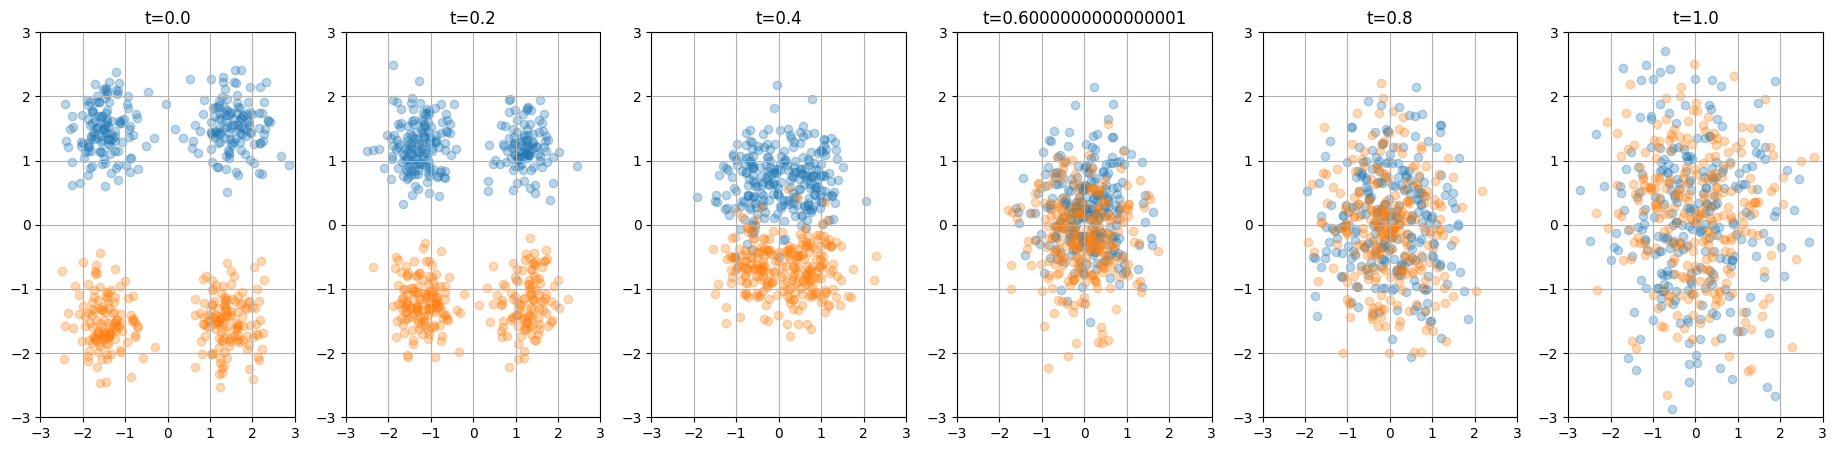

In [4]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 5)
  _, x_t_up = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t_axis[i])
  _, x_t_down = q_t(ikey[3], sample_data(ikey[2], bs//2, up=False), t_axis[i])
  plt.scatter(x_t_up[:,0], x_t_up[:,1], alpha=0.3)
  plt.scatter(x_t_down[:,0], x_t_down[:,1], alpha=0.3)
  plt.title(f't={t_axis[i]}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()

## Define the Model

In [5]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_out)(h)
    return h

def train_model(key, data_generator):
  model = MLP(num_hid=512, num_out=ndim)
  key, init_key = random.split(key)
  optimizer = optax.adam(learning_rate=2e-4)
  state = train_state.TrainState.create(apply_fn=model.apply,
                                        params=model.init(init_key, np.ones([bs,1]), np.zeros([bs,ndim])),
                                        tx=optimizer)
  
  def sm_loss(state, key, params, bs):
    keys = random.split(key, )
    sdlogqdx = lambda _t, _x: state.apply_fn(params, _t, _x)
    data = data_generator(keys[0], bs)
    t = random.uniform(keys[1], [bs,1])
    eps, x_t = q_t(keys[2], data, t)
    loss = ((eps + sdlogqdx(t, x_t))**2).sum(1)
    return loss.mean()

  @partial(jax.jit, static_argnums=1)
  def train_step(state, bs, key):
    grad_fn = jax.value_and_grad(sm_loss, argnums=2)
    loss, grads = grad_fn(state, key, state.params, bs)
    state = state.apply_gradients(grads=grads)
    return state, loss
  
  num_iterations = 20_000
  key, loop_key = random.split(key)
  for iter in trange(num_iterations):
    state, _ = train_step(state, bs, random.fold_in(loop_key, iter))
  return state

In [6]:
key, ikey = random.split(key)
state_up = train_model(ikey, partial(sample_data, up=True))
key, ikey = random.split(key)
state_down = train_model(ikey, partial(sample_data, up=False))

100%|██████████| 20000/20000 [00:19<00:00, 1050.75it/s]


## Evaluation of the Trained Model

In [7]:
# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
# dx = (v_t(x) - xi*beta_t*dlog q_t(x)/dx)dt + sqrt(2*beta_t*xi*dt)*eps
@jax.jit
def vector_field_SDE(state,t,x):
  sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
  dxdt = dlog_alphadt(t)*x - 2*beta(t)*sdlogqdx(t, x)
  return dxdt

# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
@jax.jit
def vector_field(key,t,x,state):
  eps = jax.random.randint(key, x.shape, 0, 2).astype(float)*2 - 1.0
  sdlogqdx = lambda _x: state.apply_fn(state.params, t, _x)
  sdlogdx_val, jvp_val = jax.jvp(sdlogqdx, (x,), (eps,))
  return sdlogdx_val, (jvp_val*eps).sum(1, keepdims=True)

def generate_samples(key, state):
  dt = 1e-2
  t = 1.0
  n = int(t/dt)
  t = t*jnp.ones((bs,1))
  key, ikey = random.split(key, num=2)
  x_gen = jnp.zeros((bs,n+1,ndim))
  x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, ndim)))
  for i in trange(n):
    key, ikey = random.split(key, num=2)
    dx = -dt*vector_field_SDE(state, t, x_gen[:,i,:]) + jnp.sqrt(2*jnp.exp(log_sigma(t))*beta(t)*dt)*random.normal(ikey, shape=(bs,2))
    x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
    t += -dt
  return x_gen

### Model up

100%|██████████| 100/100 [00:01<00:00, 91.59it/s]


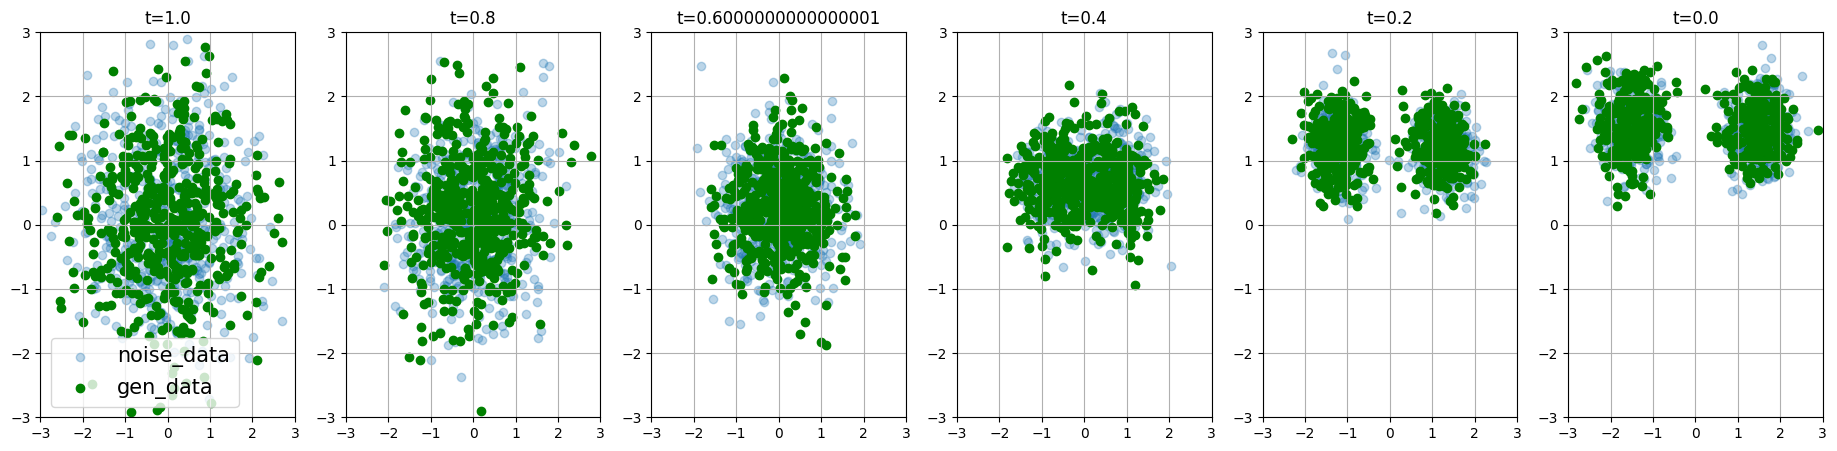

In [8]:
key, ikey = random.split(key)
x_gen = generate_samples(ikey, state_up)
x_gen_up = jnp.copy(x_gen[:,-1,:])

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

### Model down

100%|██████████| 100/100 [00:00<00:00, 205.92it/s]


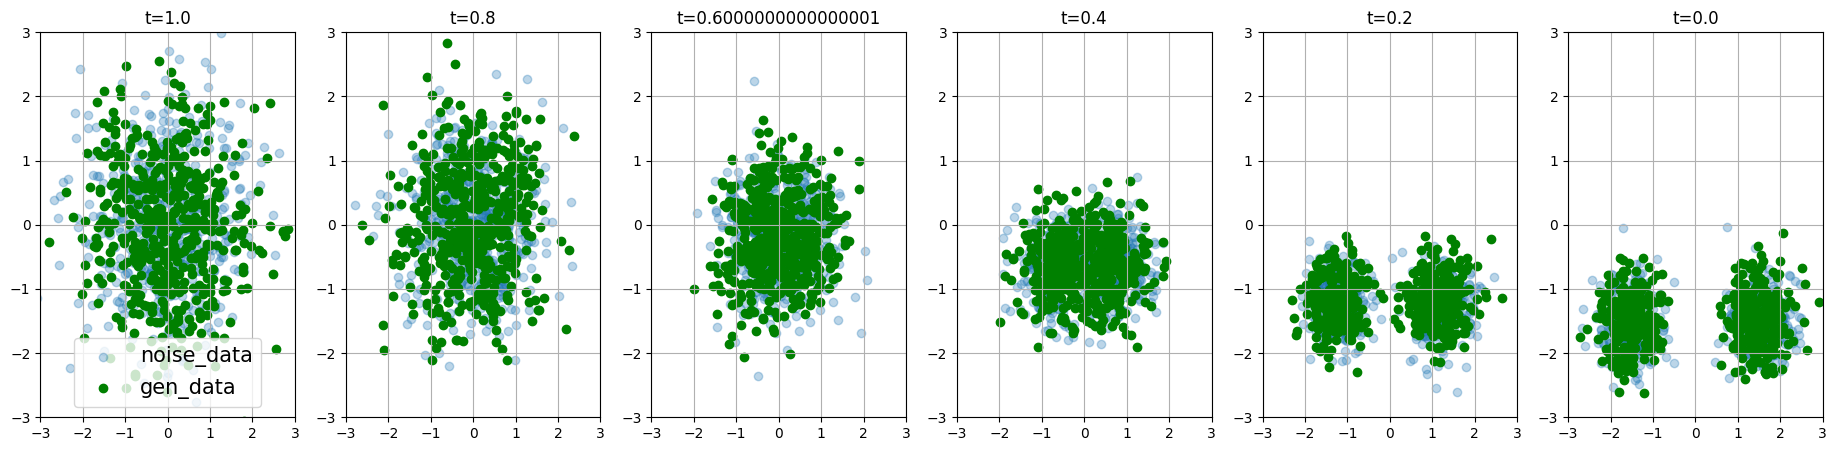

In [9]:
key, ikey = random.split(key)
x_gen = generate_samples(ikey, state_down)
x_gen_down = jnp.copy(x_gen[:,-1,:])

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(x_gen.shape[1]*(t_axis[i])),0], x_gen[:,int(x_gen.shape[1]*(t_axis[i])),1], label='gen_data', color='green')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Sampling from the isosurface (equal density of both models)

In [10]:
@jax.jit
def get_dll(t, x, sdlogdx_val, divlog_val, dxdt):
  v = dlog_alphadt(t)*x - beta(t)*sdlogdx_val
  dlldt = -dlog_alphadt(t)*ndim + beta(t)*divlog_val
  dlldt += -((sdlogdx_val/jnp.exp(log_sigma(t)))*(v-dxdt)).sum(1, keepdims=True)
  return dlldt

@jax.jit
def get_kappa(t, divlogs, sdlogdxs):
  divlog_1, divlog_2 = divlogs
  sdlogdx_1, sdlogdx_2 = sdlogdxs
  kappa = jnp.exp(log_sigma(t))*(divlog_1-divlog_2) + (sdlogdx_1*(sdlogdx_1-sdlogdx_2)).sum(1, keepdims=True)
  kappa /= ((sdlogdx_1-sdlogdx_2)**2).sum(1, keepdims=True)
  return kappa

In [11]:
bs = 512

dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
ll_1 = np.zeros((bs,n+1))
ll_2 = np.zeros((bs,n+1))
for i in trange(n):
  x_t = x_gen[:,i,:]
  key, ikey = random.split(key, num=2)
  sdlogdx_1, divdlog_1 = vector_field(ikey,t,x_t,state_up)
  sdlogdx_2, divdlog_2 = vector_field(ikey,t,x_t,state_down)
  kappa = get_kappa(t, (divdlog_1,divdlog_2),(sdlogdx_1,sdlogdx_2))
  dxdt = dlog_alphadt(t)*x_t - beta(t)*(sdlogdx_2 + kappa*(sdlogdx_1-sdlogdx_2))
  x_gen = x_gen.at[:,i+1,:].set(x_t - dt*dxdt)
  ll_1[:,i+1] = ll_1[:,i] - dt*get_dll(t, x_t, sdlogdx_1, divdlog_1, dxdt).squeeze()
  ll_2[:,i+1] = ll_2[:,i] - dt*get_dll(t, x_t, sdlogdx_2, divdlog_2, dxdt).squeeze()
  t += -dt

100%|██████████| 1000/1000 [00:14<00:00, 67.99it/s]


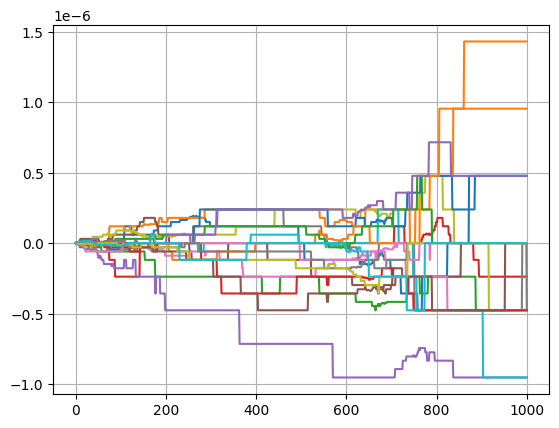

In [12]:
plt.plot((ll_1-ll_2)[:20,:].T)
plt.grid()

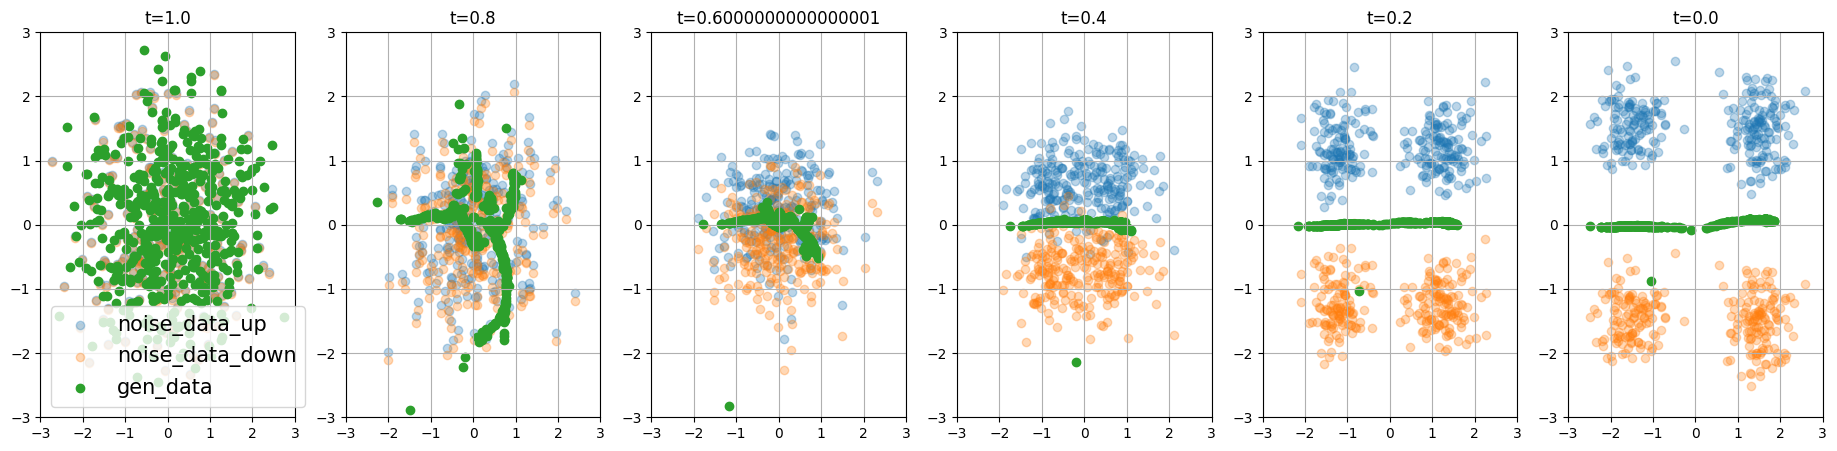

In [13]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Simple averaging

In [14]:
bs = 512

dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
ll_1 = np.zeros((bs,n+1))
ll_2 = np.zeros((bs,n+1))
for i in trange(n):
  x_t = x_gen[:,i,:]
  key, ikey = random.split(key, num=2)
  sdlogdx_1, divdlog_1 = vector_field(ikey,t,x_t,state_up)
  sdlogdx_2, divdlog_2 = vector_field(ikey,t,x_t,state_down)
  kappa = 0.5
  dxdt = dlog_alphadt(t)*x_t - beta(t)*(sdlogdx_2 + kappa*(sdlogdx_1-sdlogdx_2))
  x_gen = x_gen.at[:,i+1,:].set(x_t - dt*dxdt)
  ll_1[:,i+1] = ll_1[:,i] - dt*get_dll(t, x_t, sdlogdx_1, divdlog_1, dxdt).squeeze()
  ll_2[:,i+1] = ll_2[:,i] - dt*get_dll(t, x_t, sdlogdx_2, divdlog_2, dxdt).squeeze()
  t += -dt
  
x_gen_avg = jnp.copy(x_gen)

100%|██████████| 1000/1000 [00:12<00:00, 77.73it/s]


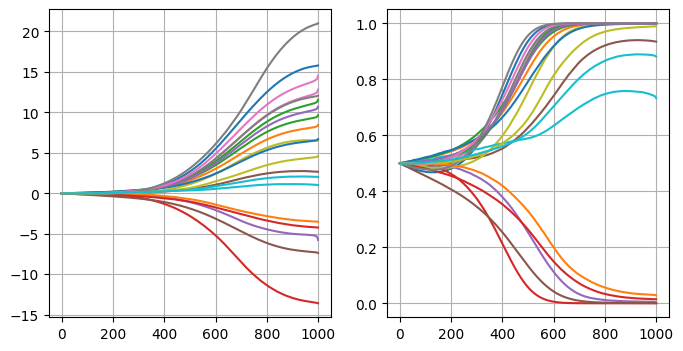

In [15]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot((ll_1-ll_2)[:20,:].T)
plt.grid()
plt.subplot(122)
plt.plot((jnp.exp(ll_1)/(jnp.exp(ll_1)+jnp.exp(ll_2)))[:20,:].T)
plt.grid()

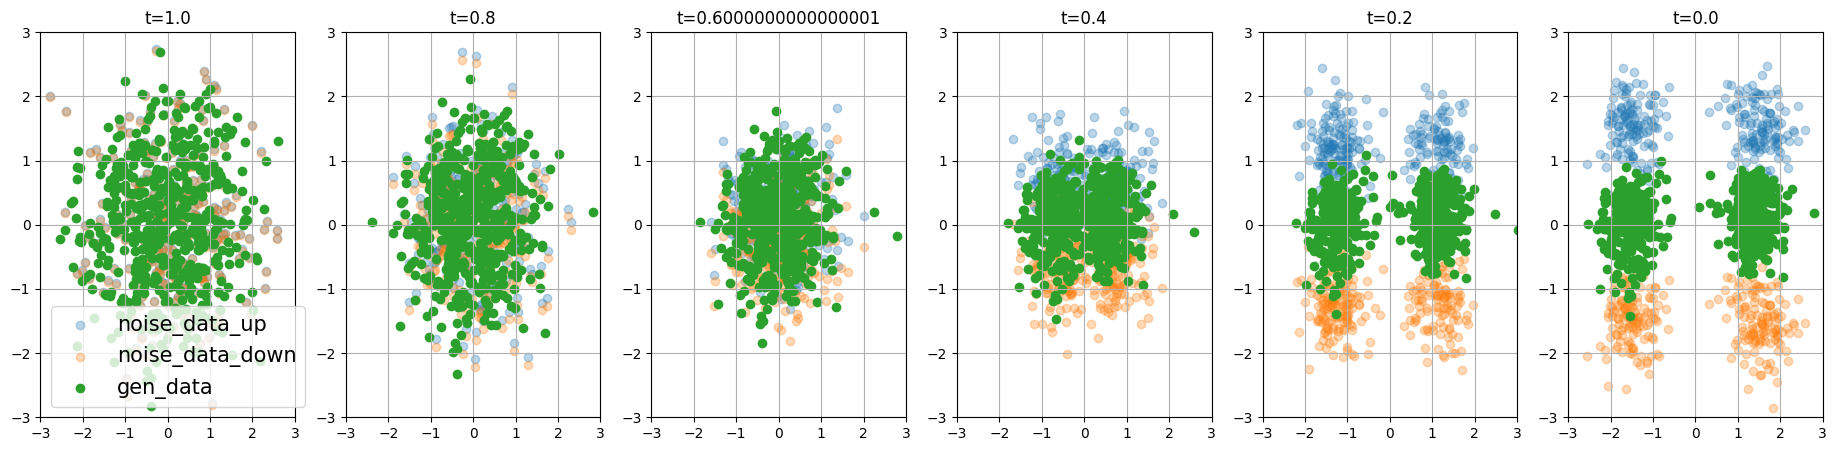

In [16]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Averaging proportionally to the density

In [18]:
bs = 512

dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
ll_1 = np.zeros((bs,n+1))
ll_2 = np.zeros((bs,n+1))
for i in trange(n):
  x_t = x_gen[:,i,:]
  key, ikey = random.split(key, num=2)
  sdlogdx_1, divdlog_1 = vector_field(ikey,t,x_t,state_up)
  sdlogdx_2, divdlog_2 = vector_field(ikey,t,x_t,state_down)
  max_ll = jnp.maximum(ll_1[:,i], ll_2[:,i])
  kappa = jnp.exp(ll_1[:,i]-max_ll) / (jnp.exp(ll_1[:,i]-max_ll) + jnp.exp(ll_2[:,i]-max_ll))
  kappa = kappa[:,None]
  dxdt = dlog_alphadt(t)*x_t - beta(t)*(sdlogdx_2 + kappa*(sdlogdx_1-sdlogdx_2))
  x_gen = x_gen.at[:,i+1,:].set(x_t - dt*dxdt)
  ll_1[:,i+1] = ll_1[:,i] - dt*get_dll(t, x_t, sdlogdx_1, divdlog_1, dxdt).squeeze()
  ll_2[:,i+1] = ll_2[:,i] - dt*get_dll(t, x_t, sdlogdx_2, divdlog_2, dxdt).squeeze()
  t += -dt

100%|██████████| 1000/1000 [00:14<00:00, 70.11it/s]


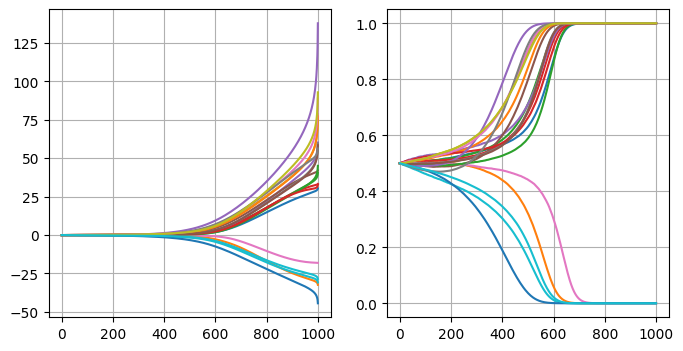

In [19]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot((ll_1-ll_2)[:20,:].T)
plt.grid()
plt.subplot(122)
plt.plot((jnp.exp(ll_1)/(jnp.exp(ll_1)+jnp.exp(ll_2)))[:20,:].T)
plt.grid()

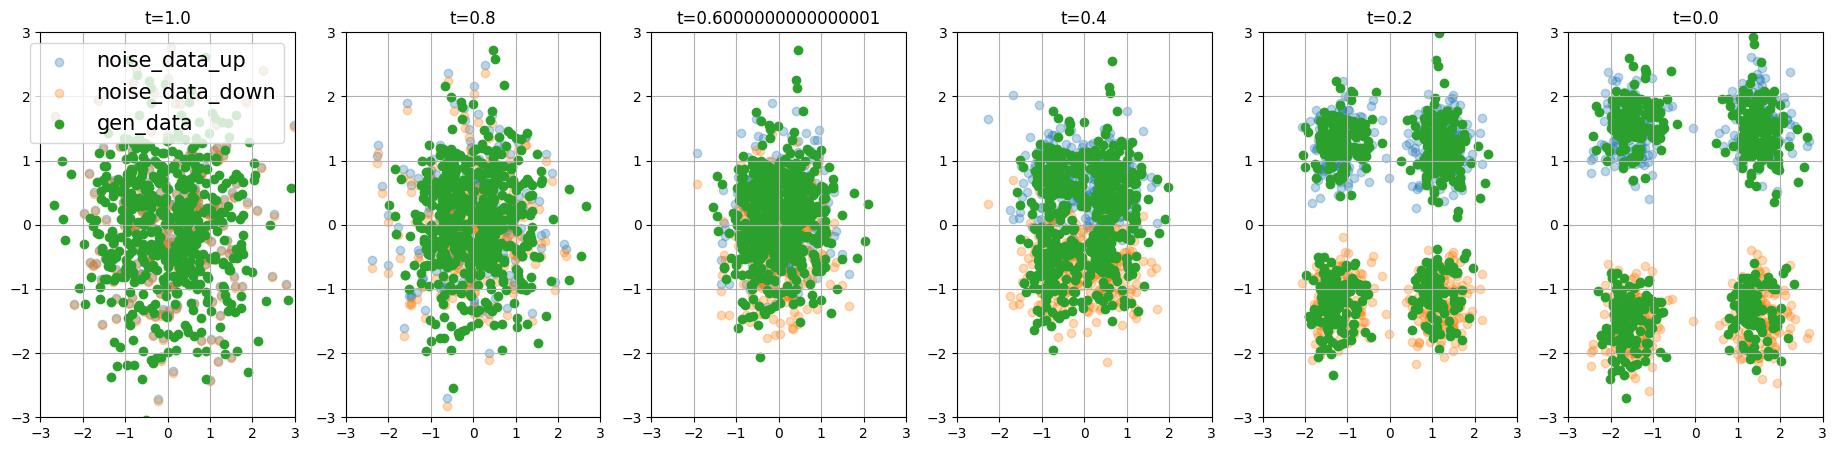

In [20]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

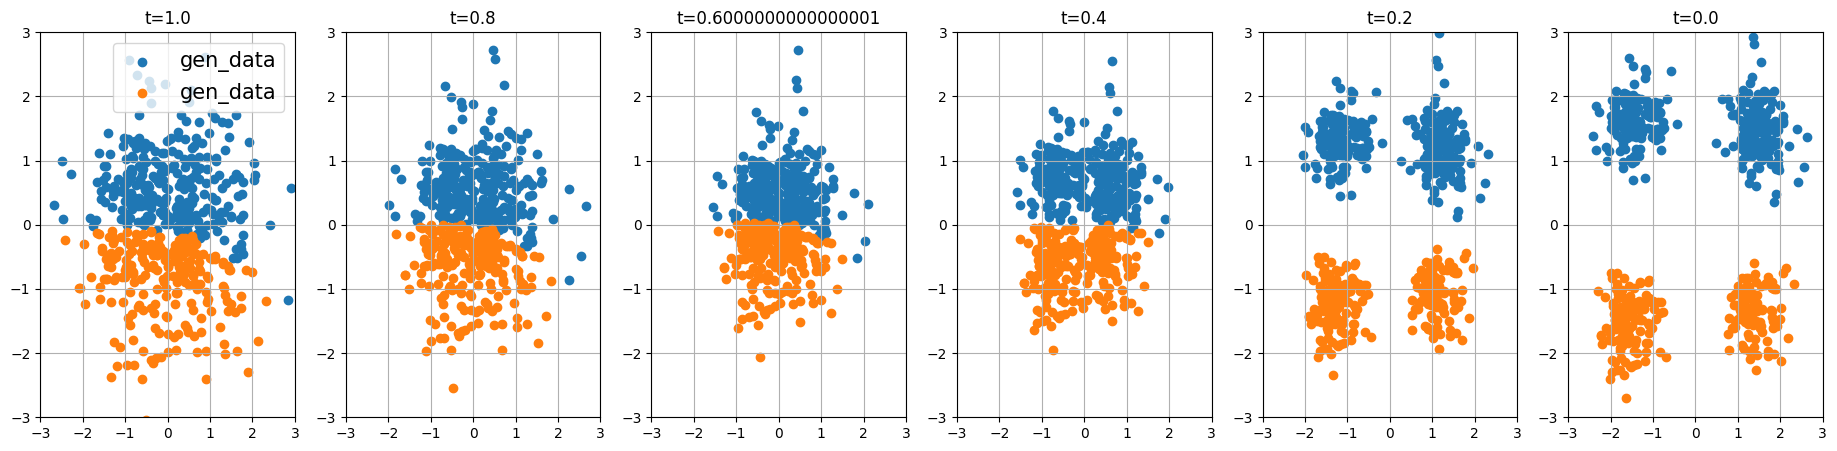

In [21]:
up_mask = ll_1[:,-1] > ll_2[:,-1]
down_mask = ll_1[:,-1] <= ll_2[:,-1]

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  plt.scatter(x_gen[up_mask,int(n*(t_axis[i])),0], x_gen[up_mask,int(n*(t_axis[i])),1], label='gen_data')
  plt.scatter(x_gen[down_mask,int(n*(t_axis[i])),0], x_gen[down_mask,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Stochastic Superposition

In [22]:
@jax.jit
def get_sscore(state,t,x):
  return state.apply_fn(state.params, t, x)

@jax.jit
def get_stoch_dll(t,dt,x,dx,sscore):
  output = ndim*dt*dlog_alphadt(t) - dt*beta(t)*(sscore**2)/jnp.exp(log_sigma(t))
  output += ((dx + dt*dlog_alphadt(t)*x)*sscore/jnp.exp(log_sigma(t)))
  return output.sum(1)

In [23]:
bs = 512

dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
ll_1 = np.zeros((bs,n+1))
ll_2 = np.zeros((bs,n+1))
for i in trange(n):
  x_t = x_gen[:,i,:]
  key, ikey = random.split(key, num=2)
  sdlogdx_1 = get_sscore(state_up,t,x_t)
  sdlogdx_2 = get_sscore(state_down,t,x_t)
  kappa = jax.nn.softmax(jnp.stack([ll_1[:,i], ll_2[:,i]]), axis=0)[0]
  kappa = kappa[:,None]
  dx = -dt*(dlog_alphadt(t)*x_t - 2*beta(t)*(sdlogdx_2 + kappa*(sdlogdx_1-sdlogdx_2)))
  dx += jnp.sqrt(2*jnp.exp(log_sigma(t))*beta(t)*dt)*random.normal(ikey, shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_t + dx)
  ll_1[:,i+1] = ll_1[:,i] + get_stoch_dll(t, dt, x_t, dx, sdlogdx_1).squeeze()
  ll_2[:,i+1] = ll_2[:,i] + get_stoch_dll(t, dt, x_t, dx, sdlogdx_2).squeeze()
  t += -dt
  
x_gen_or = jnp.copy(x_gen)

100%|██████████| 1000/1000 [00:15<00:00, 62.82it/s]


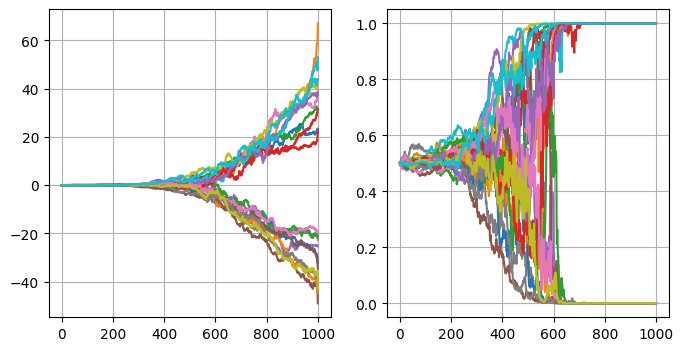

In [24]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot((ll_1-ll_2)[:20,:].T)
plt.grid()
plt.subplot(122)
plt.plot((jnp.exp(ll_1)/(jnp.exp(ll_1)+jnp.exp(ll_2)))[:20,:].T)
plt.grid()

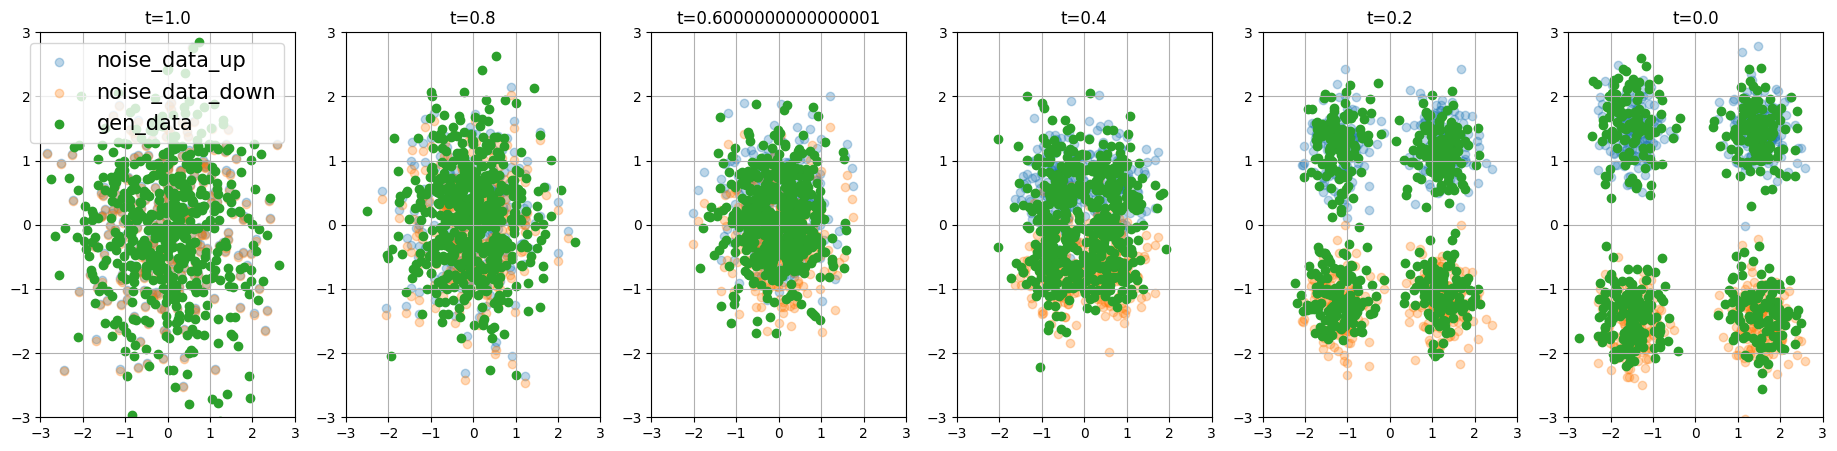

In [25]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

In [27]:
@jax.jit
def get_stoch_dll(t,dt,x,dx,sscore):
  output = ndim*dt*dlog_alphadt(t) - dt*beta(t)*(sscore**2)/jnp.exp(log_sigma(t))
  output += ((dx + dt*dlog_alphadt(t)*x)*sscore/jnp.exp(log_sigma(t)))
  return output.sum(1)

@jax.jit
def select_kappa(ikey,t,dt,x,sdlogdx_1,sdlogdx_2):
  noise = jnp.sqrt(2*jnp.exp(log_sigma(t))*beta(t)*dt)*random.normal(ikey, shape=(bs,2))
  dx_ind = -dt*(dlog_alphadt(t)*x - 2*beta(t)*sdlogdx_2) + noise
  kappa = -dt*beta(t)*(sdlogdx_1-sdlogdx_2)*(sdlogdx_1+sdlogdx_2)/jnp.exp(log_sigma(t))
  kappa += ((dx_ind + dt*dlog_alphadt(t)*x)*(sdlogdx_1-sdlogdx_2)/jnp.exp(log_sigma(t)))
  kappa = -kappa.sum(1)/(dt*2*beta(t)*(sdlogdx_1-sdlogdx_2)**2/jnp.exp(log_sigma(t))).sum(1)
  return kappa

In [28]:
bs = 512
eta = 0.9

dt = 1e-3
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
ll_0 = -0.5*(x_gen[:,0,:]**2).sum(1) - ndim*jnp.log(2*jnp.pi)
ll_1 = ll_0[:,None]*jnp.ones((bs,n+1))
ll_2 = ll_0[:,None]*jnp.ones((bs,n+1))
for i in trange(n):
  x_t = x_gen[:,i,:]
  key, ikey = random.split(key, num=2)
  sdlogdx_1 = get_sscore(state_up,t,x_t)
  sdlogdx_2 = get_sscore(state_down,t,x_t)
  kappa = select_kappa(ikey,t,dt,x_t,sdlogdx_1,sdlogdx_2)
  kappa = kappa[:,None]
  dx = -dt*(dlog_alphadt(t)*x_t - 2*beta(t)*(sdlogdx_2 + kappa*(sdlogdx_1-sdlogdx_2)))
  dx += jnp.sqrt(2*jnp.exp(log_sigma(t))*beta(t)*dt)*random.normal(ikey, shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_t + dx)
  ll_1 = ll_1.at[:,i+1].set(ll_1[:,i] + get_stoch_dll(t, dt, x_t, dx, sdlogdx_1).squeeze())
  ll_2 = ll_2.at[:,i+1].set(ll_2[:,i] + get_stoch_dll(t, dt, x_t, dx, sdlogdx_2).squeeze())
  t += -dt
  
x_gen_and = jnp.copy(x_gen)

100%|██████████| 1000/1000 [00:16<00:00, 59.41it/s]


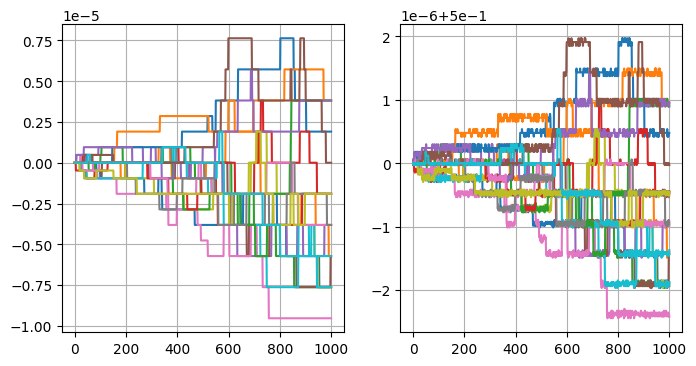

In [29]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot((ll_1-ll_2)[:20,:].T)
plt.grid()
plt.subplot(122)
plt.plot((jnp.exp(ll_1)/(jnp.exp(ll_1)+jnp.exp(ll_2)))[:20,:].T)
plt.grid()

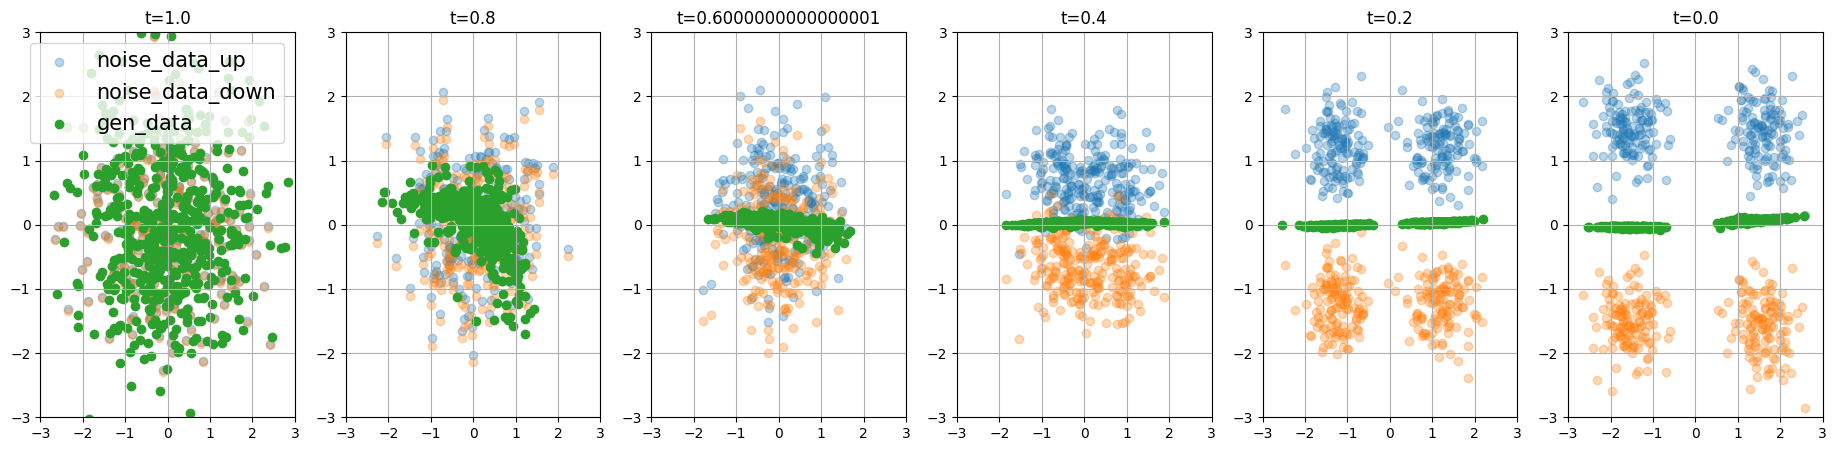

In [30]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=True), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_up', alpha=0.3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs//2, up=False), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data_down', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

In [32]:
C1="#1D9D79"
C2="#756FB3"
C3="#D96002"
alpha=0.6
alpha_3=0.7

def generate_plot(C1, C2, C3):
    # Set random seed for reproducibility
    np.random.seed(42)
    # Create a figure with 1 row and 4 columns of subplots
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    # First subplot
    axs[0].scatter(x_gen_up[:, 0], x_gen_up[:, 1], c=C1, alpha=alpha)
    axs[0].scatter(x_gen_down[:, 0], x_gen_down[:, 1], c=C2, alpha=alpha)
    # Second subplot
    axs[1].scatter(x_gen_up[:, 0], x_gen_up[:, 1], c=C1, alpha=alpha)
    axs[1].scatter(x_gen_down[:, 0], x_gen_down[:, 1], c=C2, alpha=alpha)
    axs[1].scatter(x_gen_avg[:,int(n*(t_axis[5])),0], x_gen_avg[:,int(n*(t_axis[5])),1], c=C3, alpha=alpha_3)
    # Third subplot
    axs[2].scatter(x_gen_up[:, 0], x_gen_up[:, 1], c=C1, alpha=alpha)
    axs[2].scatter(x_gen_down[:, 0], x_gen_down[:, 1], c=C2, alpha=alpha)
    axs[2].scatter(x_gen_or[:,int(n*(t_axis[5])),0], x_gen_or[:,int(n*(t_axis[5])),1], c=C3, alpha=alpha_3)
    # Fourth subplot
    axs[3].scatter(x_gen_up[:, 0], x_gen_up[:, 1], c=C1, alpha=alpha)
    axs[3].scatter(x_gen_down[:, 0], x_gen_down[:, 1], c=C2, alpha=alpha)
    axs[3].scatter(x_gen_and[:,int(n*(t_axis[5])),0], x_gen_and[:,int(n*(t_axis[5])),1], c=C3, alpha=alpha_3)
    # Set limits and titles for each subplot
    ms=1.6
    for ax in axs:
        ax.set_xlim(-ms*2, ms*2)
        ax.set_ylim(-ms*2, ms*2)
        ax.set_xticks([])  # Remove x-axis ticks
        ax.set_xticklabels([])  # Remove x-axis labels
        ax.set_yticks([])  # Remove y-axis ticks
        ax.set_yticklabels([])  # Remove y-axis labels
        
    dummy_l1 = axs[4].scatter([], [], c=C1, label='Train Data A', s=90., alpha=1)
    dummy_l2 = axs[4].scatter([], [], c=C2, label='Train Data B', s=90., alpha=1)
    dummy_l3 = axs[4].scatter([], [], c=C3, label='Generated samples', s=90., alpha=1)
    
    axs[4].spines['top'].set_visible(False)
    axs[4].spines['bottom'].set_visible(False)
    axs[4].spines['left'].set_visible(False)
    axs[4].spines['right'].set_visible(False)

    # Add a single legend outside the plots on the right
    fig.legend(handles=[dummy_l1, dummy_l2, dummy_l3], loc='center left', bbox_to_anchor=(0.767, 0.5), 
               ncol=3, prop={'family': 'monospace', 'size': 16})


    # Show the plot
    #plt.tight_layout()
    os.makedirs("fig1_toy_example", exist_ok=True)
    for i, ax in enumerate(axs):
        extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        if i == 0:
            plt.savefig("fig1_toy_example/toy-data.pdf", dpi=300, bbox_inches=extent.expanded(1.1, 1.1))
        elif i == 1:
            plt.savefig("fig1_toy_example/toy-average.pdf", dpi=300, bbox_inches=extent.expanded(1.1, 1.1))
        elif i == 2:
            plt.savefig("fig1_toy_example/toy-mixture.pdf", dpi=300, bbox_inches=extent.expanded(1.1, 1.1))
        elif i == 3:
            plt.savefig("fig1_toy_example/toy-eq-density.pdf", dpi=300, bbox_inches=extent.expanded(1.1, 1.1))
        elif i == 4:
            print(extent)
            extent.x1 += 5.5
            extent.y0 = 2.2
            extent.y1 = 2.8
            plt.savefig("fig1_toy_example/toy-legend.pdf", dpi=300, bbox_inches=extent)
    plt.show()

Bbox(x0=19.15948275862069, y0=0.5499999999999999, x1=22.500000000000004, y1=4.4)


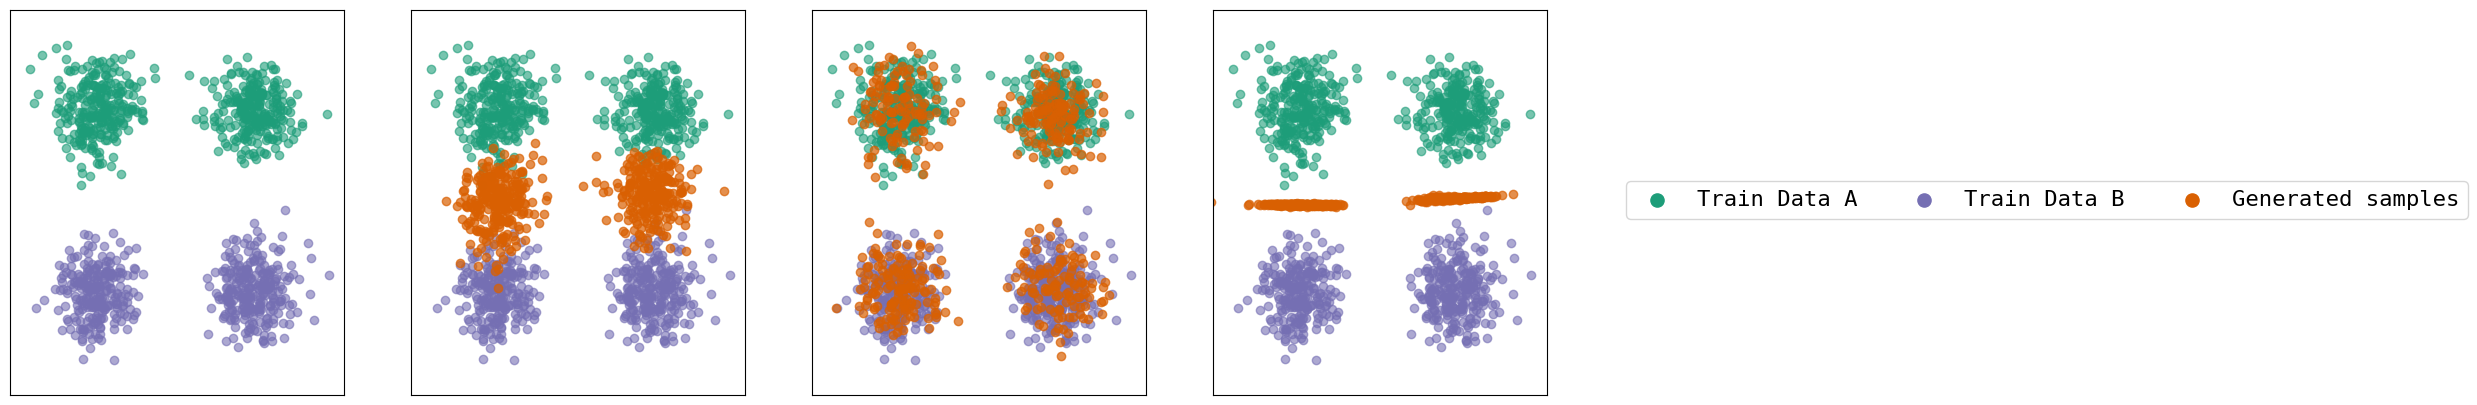

In [33]:
generate_plot(C1, C2, C3)